In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from core.engine import preprocess
from core.mcmc import run_chain
import tensorflow as tf

import tensorflow_probability as tfp
from core.data import get_companions, extend_psf

%load_ext autoreload
%autoreload 2

2023-07-18 23:00:55.846105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 23:00:55.982314: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

In [3]:
_, cube, psf, rot_angles, backmoments = preprocess('./data/real/f_dhtau', 
                                                       lambda_ch=0, 
                                                       load_preprocessed=True)
psf = psf[:-1]
table = pd.read_csv('./logs/comparison/tf/fake/w12/prediction.csv')

In [4]:
table = table[table['snr'] > 70]

In [5]:
%%time
for index, row in table.iterrows():    
    x = row['optimal_x']
    y = row['optimal_y']
    flux = row['optimal_flux']
    window_size = psf.shape[-1]
    companion = get_companions(cube, 
                           x=x, 
                           y=y, 
                           window_size=window_size)
    psf_ext = extend_psf(psf, companion)
    
    results = run_chain(flux, companion, psf_ext, rot_angles, num_results=1000)
    
    break

2023-07-18 23:01:03.408480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 23:01:03.422720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 23:01:03.423550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

(317520,)


/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 4min 46s, sys: 7.52 s, total: 4min 54s
Wall time: 4min 8s


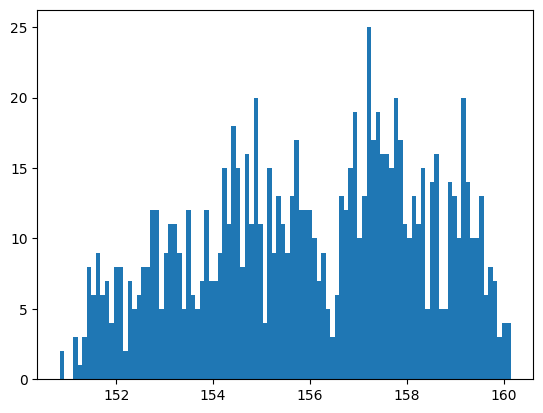

In [54]:
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(1, 1)
for i, r in enumerate(results.all_states):
    ax.hist(r.numpy(), bins=100)

# stats

In [36]:
max_value = tfp.stats.percentile(companion, q=25)
min_value = tf.reduce_min(companion)
mask = tf.where(companion < max_value, 1., 0.)
p25_companion = companion * mask

values = tf.reshape(p25_companion, -1)

non_zero_mask = tf.where(values != 0, True, False)
valid = tf.boolean_mask(values, non_zero_mask)

median = tfp.stats.percentile(valid, q=50)
std = tf.math.reduce_std(valid)

Text(0.5, 1.0, "Companion's \n 25 Percentile")

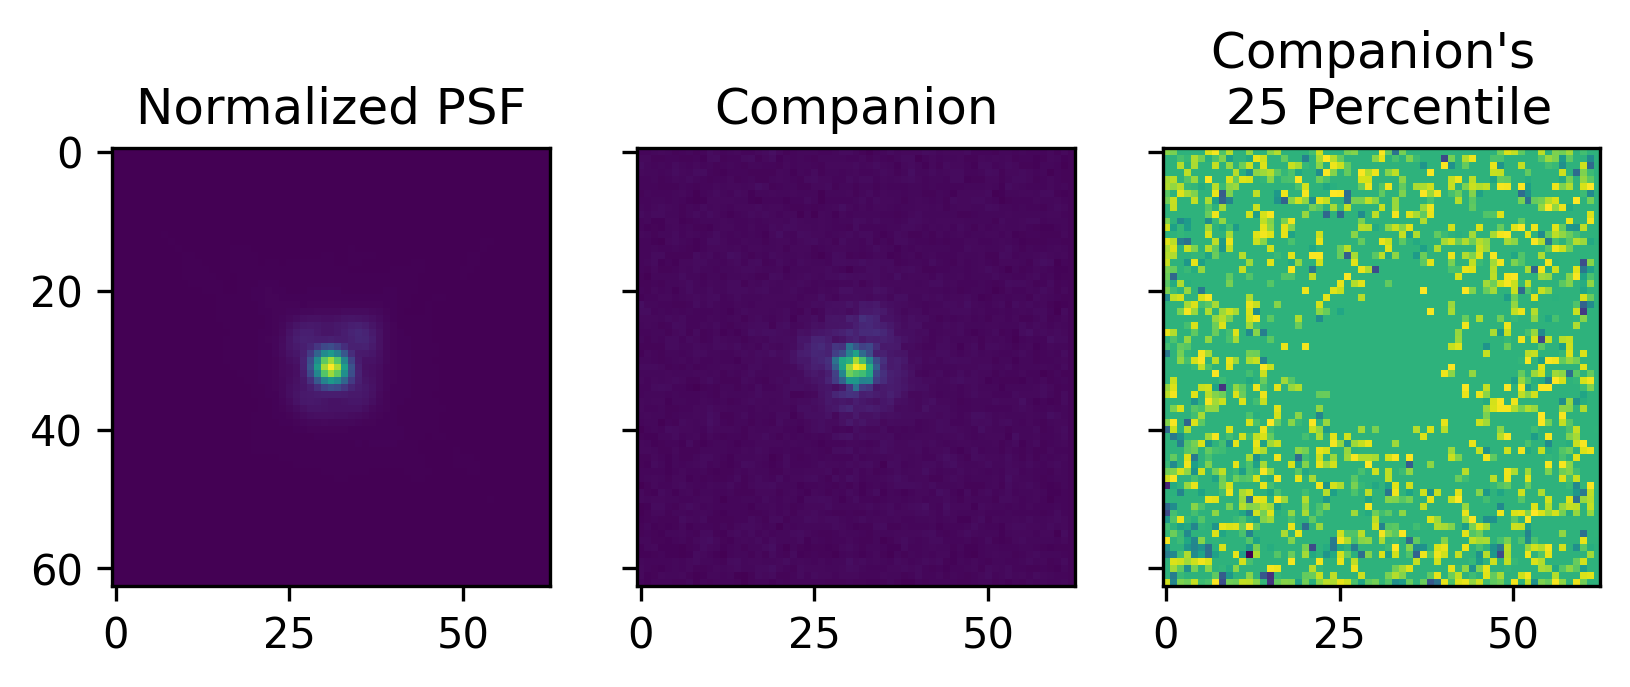

In [49]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(psf[0])
axes[1].imshow(companion[0])
axes[2].imshow(p25_companion[0])

axes[0].set_title('Normalized PSF')
axes[1].set_title('Companion')
axes[2].set_title("Companion's \n 25 Percentile")